
## RNNs for time series data


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


In [5]:

## !pip install torch


In [6]:

import matplotlib 
## import pytorch_lightning as pl
import torch 


In [7]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [8]:

daily_temp = pd.read_csv('data/daily_weather.csv', 
                          index_col='DateTime', 
                          parse_dates=True
)

daily_temp.columns = ['y']

energy = pd.read_csv('data/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True
)

energy.columns = ['y']

air = pd.read_csv('data/air_passenger.csv', 
                  index_col='date', 
                  parse_dates=True)

air.columns = ['y']


In [9]:

daily_temp.index.freq = 'D'
energy.index.freq     = 'MS'
air.index.freq        = 'M'


In [10]:

print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)


<Day>
<MonthBegin>
<MonthEnd>


<Axes: title={'center': 'Monthly Passengers'}, xlabel='date'>

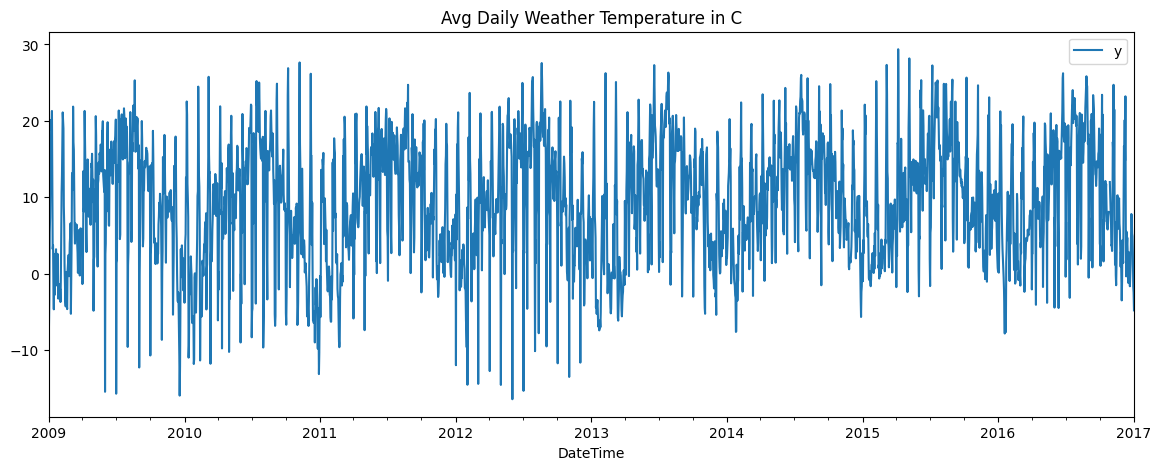

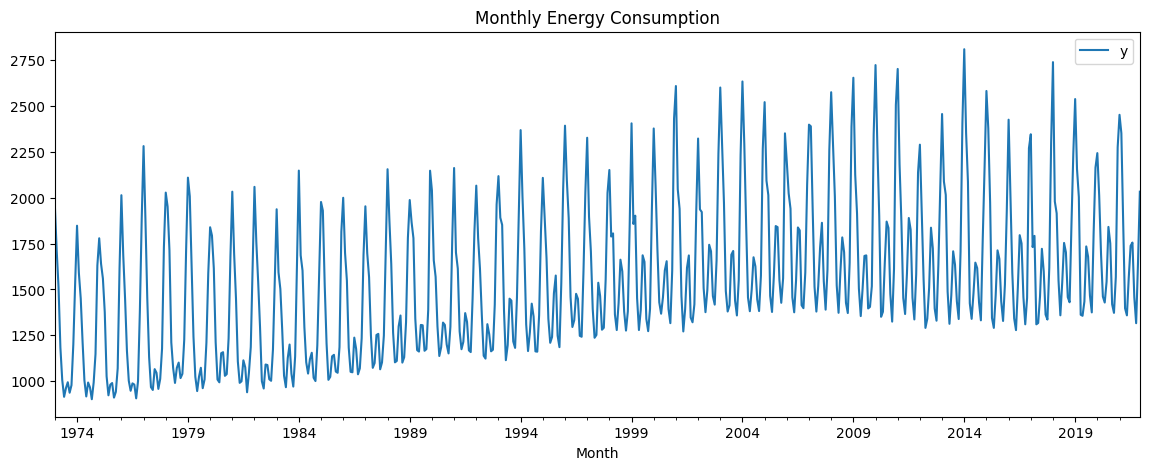

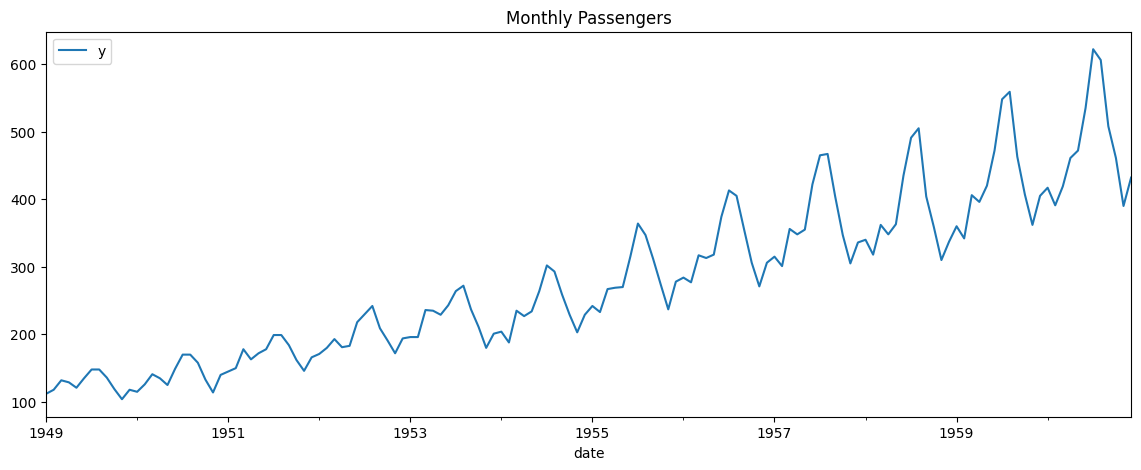

In [11]:

plt.rcParams["figure.figsize"] = [14, 5]  

daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(    title='Monthly Energy Consumption')
air.plot(       title='Monthly Passengers')


In [12]:

daily_temp.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2921 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


In [13]:

energy.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [14]:

air.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [15]:

def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        

In [16]:

def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    



In [17]:


def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test



In [18]:

air_cp = air.copy()
en_cp  = energy.copy()
dw_cp  = daily_temp.copy()


In [19]:

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)


found 2 missing observations...



## Converts data into time window approach with 10 steps 


In [21]:

air_df = one_step_forecast(air_cp, 10)
en_df  = one_step_forecast(en_cp, 10)
dw_df  = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)


(134, 11)
(578, 11)
(2913, 11)


In [22]:

class Standardize:
    
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [23]:

scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()


In [24]:

print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')



air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



In [25]:

def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x


In [26]:

numpy_array = train_air.values
type(numpy_array)


numpy.ndarray


## To convert to torch tensors 


In [27]:

torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)


torch.Tensor

In [28]:

from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)


numpy.ndarray

In [29]:

(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_pt(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_pt(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)


In [30]:

# returns a Tensor object
type(x_test_air)


torch.Tensor

In [31]:

y_train_air.shape


torch.Size([109, 1])

In [35]:

x_train_air.shape


torch.Size([109, 10, 1])


## RNN/LSTM in PyTorch
RNN Model

The math from the PyTorch RNN class documentation



In [36]:

class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden


In [37]:

issubclass(RNN, nn.Module)


True

In [38]:

issubclass(RNN, nn.RNN)


False

In [39]:

def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history



## Air Passenger


In [40]:

params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}


0/500 - Loss:  1.0981844663619995, val_loss: 1.889482021331787
25/500 - Loss:  0.0847334936261177, val_loss: 0.5032091736793518
50/500 - Loss:  0.03791417181491852, val_loss: 0.2370314747095108
75/500 - Loss:  0.03084399737417698, val_loss: 0.19180814921855927
100/500 - Loss:  0.028598150238394737, val_loss: 0.17820505797863007
125/500 - Loss:  0.021603645756840706, val_loss: 0.13887418806552887
150/500 - Loss:  0.018665209412574768, val_loss: 0.12202312797307968
175/500 - Loss:  0.020825544372200966, val_loss: 0.15944533050060272
200/500 - Loss:  0.02020670659840107, val_loss: 0.13244807720184326
225/500 - Loss:  0.017420589923858643, val_loss: 0.1609288901090622
250/500 - Loss:  0.015888459980487823, val_loss: 0.1594584733247757
275/500 - Loss:  0.01789228431880474, val_loss: 0.17929582297801971
300/500 - Loss:  0.020101794973015785, val_loss: 0.20867544412612915
325/500 - Loss:  0.021381808444857597, val_loss: 0.20520798861980438
350/500 - Loss:  0.016862688586115837, val_loss: 0.14

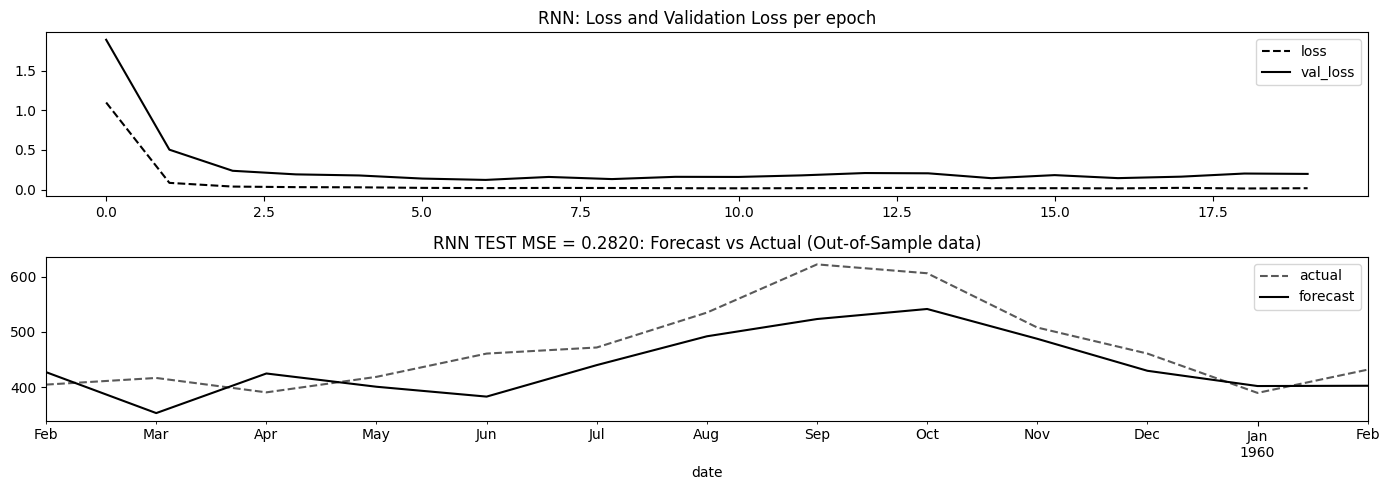

In [41]:

air_rnn, history_a_rnn = train_model_pt('RNN', **params_air)



## Avg Daily Temperature


0/500 - Loss:  1.089613914489746, val_loss: 0.7357838153839111
20/500 - Loss:  0.4128790497779846, val_loss: 0.3910005986690521
40/500 - Loss:  0.38111594319343567, val_loss: 0.3491874039173126
60/500 - Loss:  0.3539445698261261, val_loss: 0.3642295300960541
80/500 - Loss:  0.3225124180316925, val_loss: 0.3760685622692108
100/500 - Loss:  0.2981838285923004, val_loss: 0.39306768774986267
120/500 - Loss:  0.2806739807128906, val_loss: 0.402213990688324
140/500 - Loss:  0.25039875507354736, val_loss: 0.44581112265586853
160/500 - Loss:  0.24329373240470886, val_loss: 0.4286164939403534
180/500 - Loss:  0.25709959864616394, val_loss: 0.41283777356147766
200/500 - Loss:  0.22674374282360077, val_loss: 0.3949938714504242
220/500 - Loss:  0.21883542835712433, val_loss: 0.43969225883483887
240/500 - Loss:  0.2233232855796814, val_loss: 0.4431985318660736
260/500 - Loss:  0.20921069383621216, val_loss: 0.4666118025779724
280/500 - Loss:  0.20942683517932892, val_loss: 0.4177384674549103
300/50

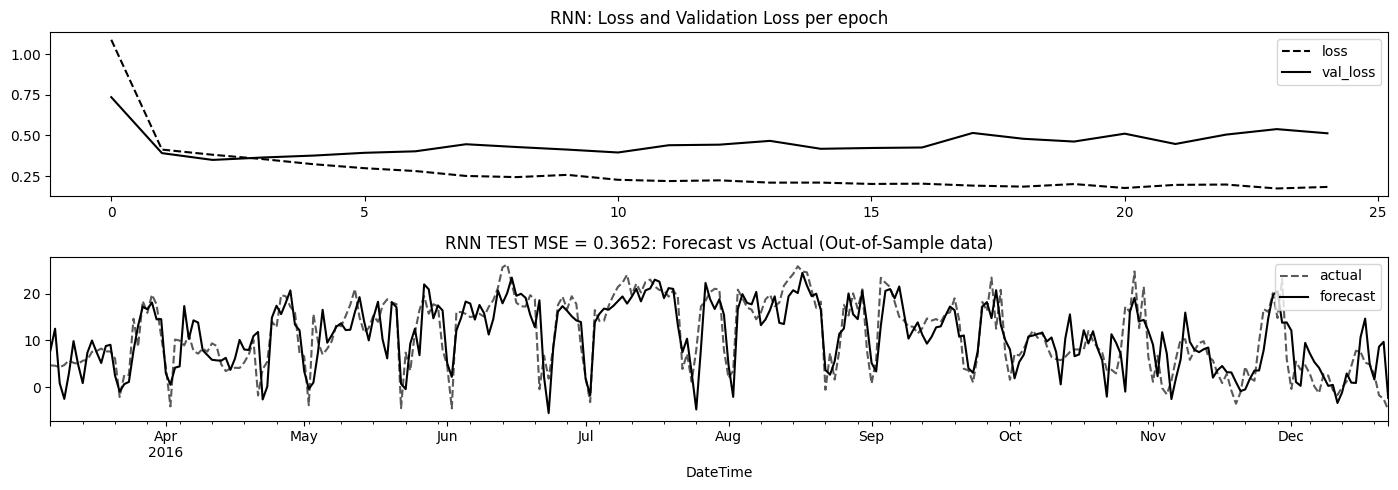

In [42]:

params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train_model_pt('RNN', **params_dw)



## Energy Consumption


0/500 - Loss:  1.0570183992385864, val_loss: 1.0438685417175293
20/500 - Loss:  0.08798640221357346, val_loss: 0.16191598773002625
40/500 - Loss:  0.08701632171869278, val_loss: 0.14111119508743286
60/500 - Loss:  0.07101210206747055, val_loss: 0.14204534888267517
80/500 - Loss:  0.06388422846794128, val_loss: 0.13917039334774017
100/500 - Loss:  0.05556269735097885, val_loss: 0.13818813860416412
120/500 - Loss:  0.05352005735039711, val_loss: 0.13356687128543854
140/500 - Loss:  0.047963619232177734, val_loss: 0.12678898870944977
160/500 - Loss:  0.05122577026486397, val_loss: 0.13012060523033142
180/500 - Loss:  0.043907031416893005, val_loss: 0.1290311962366104
200/500 - Loss:  0.049796100705862045, val_loss: 0.12216564267873764
220/500 - Loss:  0.04574359580874443, val_loss: 0.12076899409294128
240/500 - Loss:  0.04381159320473671, val_loss: 0.12439414113759995
260/500 - Loss:  0.043564774096012115, val_loss: 0.11814815551042557
280/500 - Loss:  0.04110291227698326, val_loss: 0.121

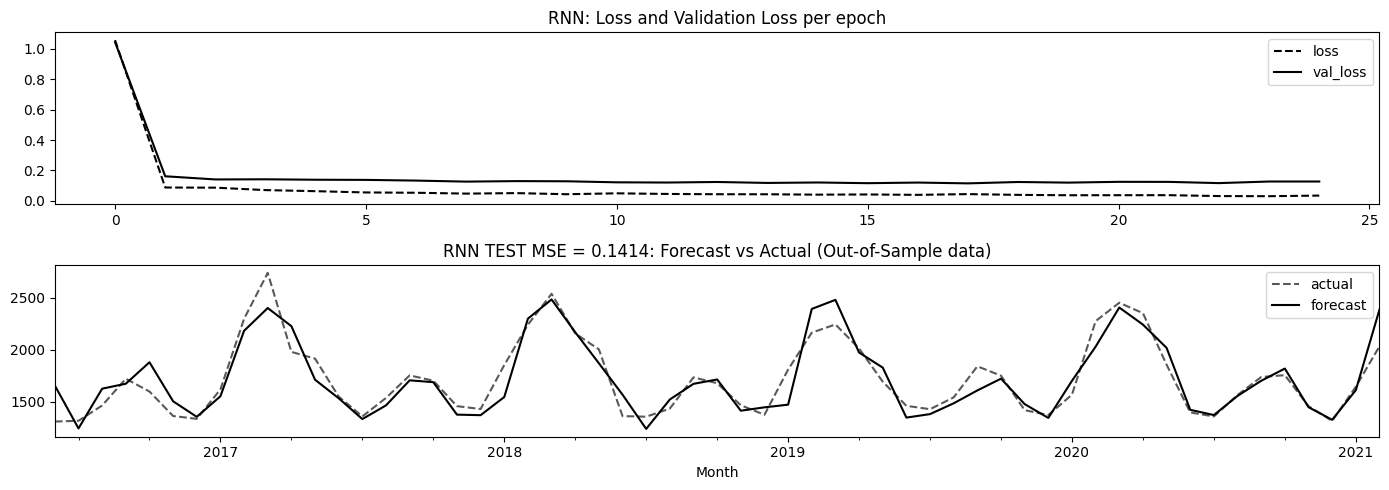

In [43]:

params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train_model_pt('RNN', **params_en)



## LSTM Model


In [44]:

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden



## Air Passenger


0/500 - Loss:  0.9533987641334534, val_loss: 2.244997978210449
25/500 - Loss:  0.09236354380846024, val_loss: 0.4230436384677887
50/500 - Loss:  0.044540274888277054, val_loss: 0.5641049742698669
75/500 - Loss:  0.0362255796790123, val_loss: 0.5177241563796997
100/500 - Loss:  0.028790665790438652, val_loss: 0.3808985650539398
125/500 - Loss:  0.028605561703443527, val_loss: 0.3497546911239624
150/500 - Loss:  0.01933135651051998, val_loss: 0.29667285084724426
175/500 - Loss:  0.026021292433142662, val_loss: 0.32002463936805725
200/500 - Loss:  0.018881333991885185, val_loss: 0.34669235348701477
225/500 - Loss:  0.029213445261120796, val_loss: 0.2535400092601776
250/500 - Loss:  0.01390757691115141, val_loss: 0.2773968577384949
275/500 - Loss:  0.022314876317977905, val_loss: 0.3290068209171295
300/500 - Loss:  0.014591354876756668, val_loss: 0.35843750834465027
325/500 - Loss:  0.01811336539685726, val_loss: 0.2381475418806076
350/500 - Loss:  0.0187786053866148, val_loss: 0.325088888

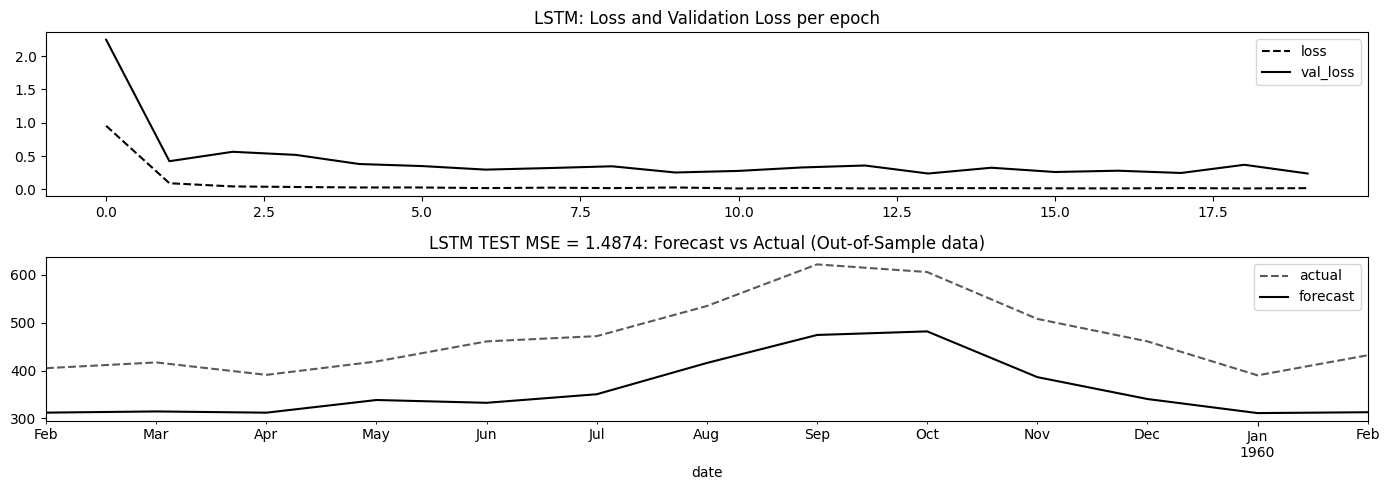

In [45]:

air_lstm, history_a_lstm = train_model_pt('LSTM', **params_air)



## Avg Daily Temperature


0/500 - Loss:  0.9131253361701965, val_loss: 0.7296143770217896
20/500 - Loss:  0.4010465145111084, val_loss: 0.34338533878326416
40/500 - Loss:  0.3306041955947876, val_loss: 0.3300103545188904
60/500 - Loss:  0.28421828150749207, val_loss: 0.311334490776062
80/500 - Loss:  0.2677760124206543, val_loss: 0.3089463412761688
100/500 - Loss:  0.2376955896615982, val_loss: 0.2988317012786865
120/500 - Loss:  0.2085978090763092, val_loss: 0.318430632352829
140/500 - Loss:  0.19724366068840027, val_loss: 0.31923407316207886
160/500 - Loss:  0.1852952539920807, val_loss: 0.3125993013381958
180/500 - Loss:  0.1750708669424057, val_loss: 0.3020403981208801
200/500 - Loss:  0.15421324968338013, val_loss: 0.31176936626434326
220/500 - Loss:  0.15070690214633942, val_loss: 0.3146407902240753
240/500 - Loss:  0.1467689424753189, val_loss: 0.340767502784729
260/500 - Loss:  0.14192745089530945, val_loss: 0.35121598839759827
280/500 - Loss:  0.13417282700538635, val_loss: 0.35800468921661377
300/500 

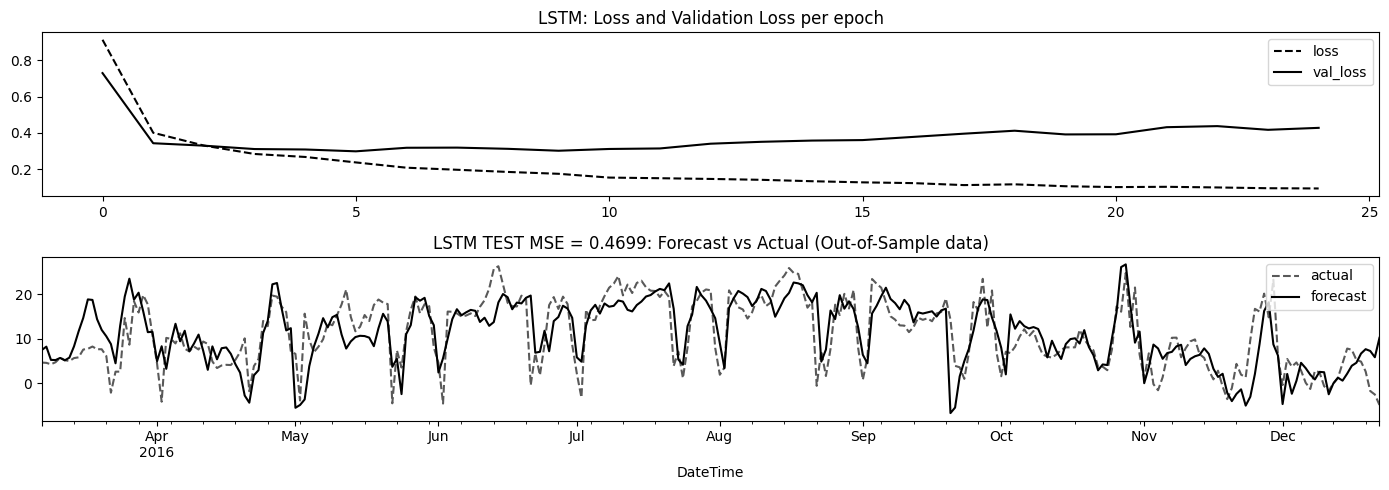

In [46]:

dw_lstm, history_dw_lstm = train_model_pt('LSTM', **params_dw)



## Energy Consumption


0/500 - Loss:  1.0766491889953613, val_loss: 1.4864733219146729
20/500 - Loss:  0.13079208135604858, val_loss: 0.30831050872802734
40/500 - Loss:  0.08600129932165146, val_loss: 0.21801450848579407
60/500 - Loss:  0.06781034916639328, val_loss: 0.19040676951408386
80/500 - Loss:  0.06100041791796684, val_loss: 0.17964093387126923
100/500 - Loss:  0.05463842302560806, val_loss: 0.16901959478855133
120/500 - Loss:  0.05373002961277962, val_loss: 0.16446463763713837
140/500 - Loss:  0.05295248702168465, val_loss: 0.15980090200901031
160/500 - Loss:  0.04860664904117584, val_loss: 0.15089628100395203
180/500 - Loss:  0.04585694521665573, val_loss: 0.14836767315864563
200/500 - Loss:  0.046998120844364166, val_loss: 0.144103541970253
220/500 - Loss:  0.03959368169307709, val_loss: 0.1353912204504013
240/500 - Loss:  0.038484249264001846, val_loss: 0.13658703863620758
260/500 - Loss:  0.03453454375267029, val_loss: 0.1459442526102066
280/500 - Loss:  0.03314068168401718, val_loss: 0.14685574

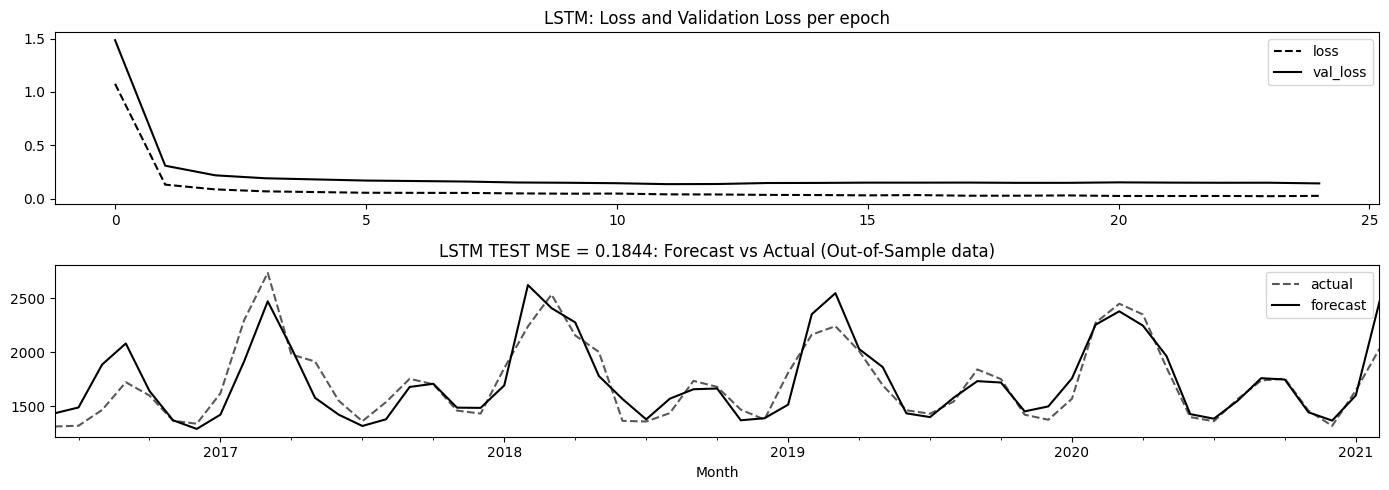

In [47]:

en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)



## LSTM with Dropout


In [48]:

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden


0/500 - Loss:  1.0574350357055664, val_loss: 1.3231220245361328
20/500 - Loss:  0.13756196200847626, val_loss: 0.2902069687843323
40/500 - Loss:  0.0831548273563385, val_loss: 0.21182456612586975
60/500 - Loss:  0.0667734146118164, val_loss: 0.1819809079170227
80/500 - Loss:  0.05956945940852165, val_loss: 0.1713273823261261
100/500 - Loss:  0.052497152239084244, val_loss: 0.16349895298480988
120/500 - Loss:  0.06014319509267807, val_loss: 0.15646694600582123
140/500 - Loss:  0.05244293436408043, val_loss: 0.1547916978597641
160/500 - Loss:  0.048037465661764145, val_loss: 0.1485612988471985
180/500 - Loss:  0.04370011016726494, val_loss: 0.14476919174194336
200/500 - Loss:  0.048332083970308304, val_loss: 0.14276225864887238
220/500 - Loss:  0.044984690845012665, val_loss: 0.14322775602340698
240/500 - Loss:  0.03435245156288147, val_loss: 0.13596627116203308
260/500 - Loss:  0.04031533747911453, val_loss: 0.13663822412490845
280/500 - Loss:  0.03789983317255974, val_loss: 0.135063037

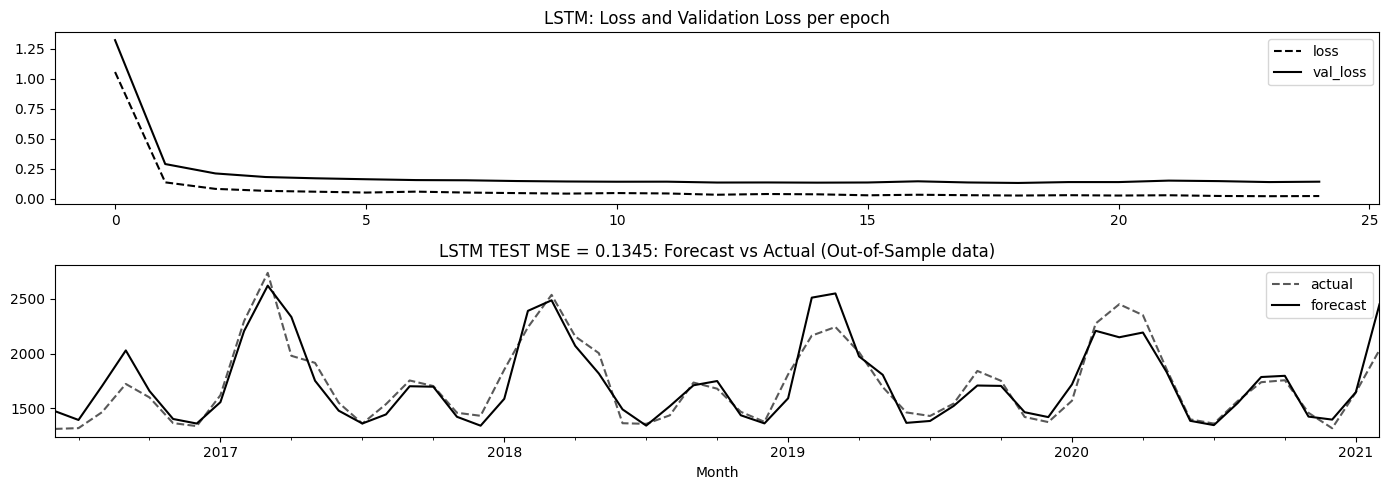

In [49]:

en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)



## GRU


In [50]:

class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden



## Air Passenger


0/500 - Loss:  0.7809235453605652, val_loss: 2.0969724655151367
25/500 - Loss:  0.08212120831012726, val_loss: 0.415833443403244
50/500 - Loss:  0.050647202879190445, val_loss: 0.8419210910797119
75/500 - Loss:  0.030486319214105606, val_loss: 0.8409216403961182
100/500 - Loss:  0.0263610128313303, val_loss: 0.758355438709259
125/500 - Loss:  0.025259610265493393, val_loss: 0.7317180633544922
150/500 - Loss:  0.028582267463207245, val_loss: 0.5154955983161926
175/500 - Loss:  0.02508586458861828, val_loss: 0.5784668922424316
200/500 - Loss:  0.020797230303287506, val_loss: 0.7139607071876526
225/500 - Loss:  0.0270821675658226, val_loss: 0.7450294494628906
250/500 - Loss:  0.03340975567698479, val_loss: 0.5679653882980347
275/500 - Loss:  0.01608266495168209, val_loss: 0.6491104960441589
300/500 - Loss:  0.019526800140738487, val_loss: 0.5781328678131104
325/500 - Loss:  0.019677655771374702, val_loss: 0.6186560988426208
350/500 - Loss:  0.019967971369624138, val_loss: 0.62343662977218

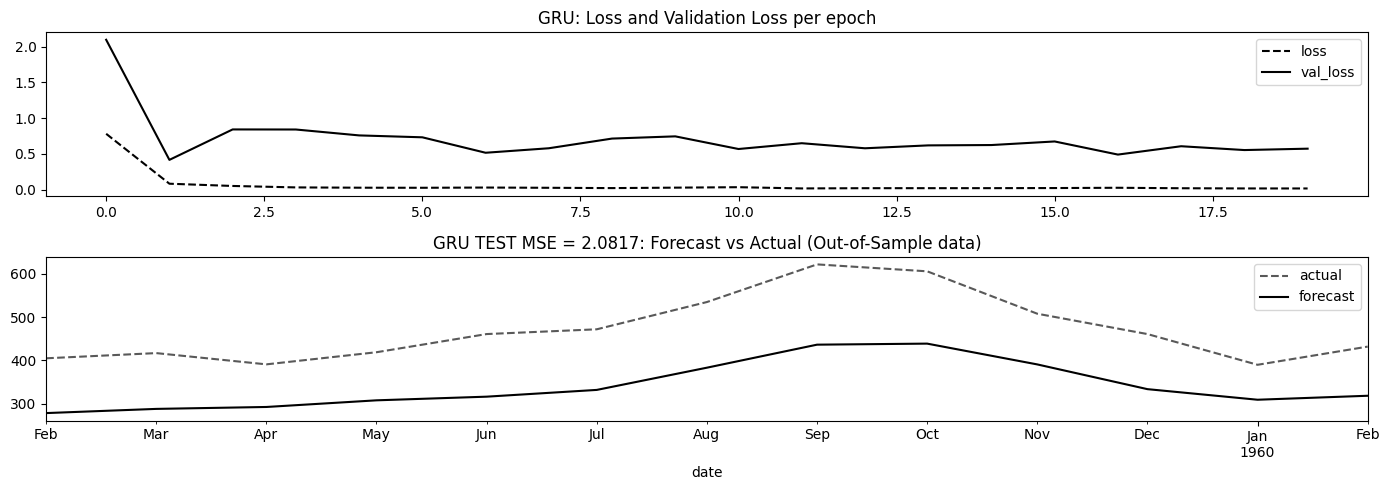

In [51]:

air_gru, history_a_gru = train_model_pt('GRU', **params_air)



## Avg Daily Temperature


0/500 - Loss:  1.0243736505508423, val_loss: 0.8249356746673584
20/500 - Loss:  0.4186929762363434, val_loss: 0.37706318497657776
40/500 - Loss:  0.3539167642593384, val_loss: 0.34705403447151184
60/500 - Loss:  0.31332311034202576, val_loss: 0.32493191957473755
80/500 - Loss:  0.28281548619270325, val_loss: 0.2830028831958771
100/500 - Loss:  0.24341294169425964, val_loss: 0.3378962576389313
120/500 - Loss:  0.21261681616306305, val_loss: 0.3432238698005676
140/500 - Loss:  0.2248716503381729, val_loss: 0.3036169409751892
160/500 - Loss:  0.1897517889738083, val_loss: 0.30834755301475525
180/500 - Loss:  0.18387961387634277, val_loss: 0.2872505486011505
200/500 - Loss:  0.17307686805725098, val_loss: 0.2929690182209015
220/500 - Loss:  0.16234679520130157, val_loss: 0.27909421920776367
240/500 - Loss:  0.14375562965869904, val_loss: 0.28086328506469727
260/500 - Loss:  0.14422786235809326, val_loss: 0.2926255464553833
280/500 - Loss:  0.1312156617641449, val_loss: 0.2923372685909271
3

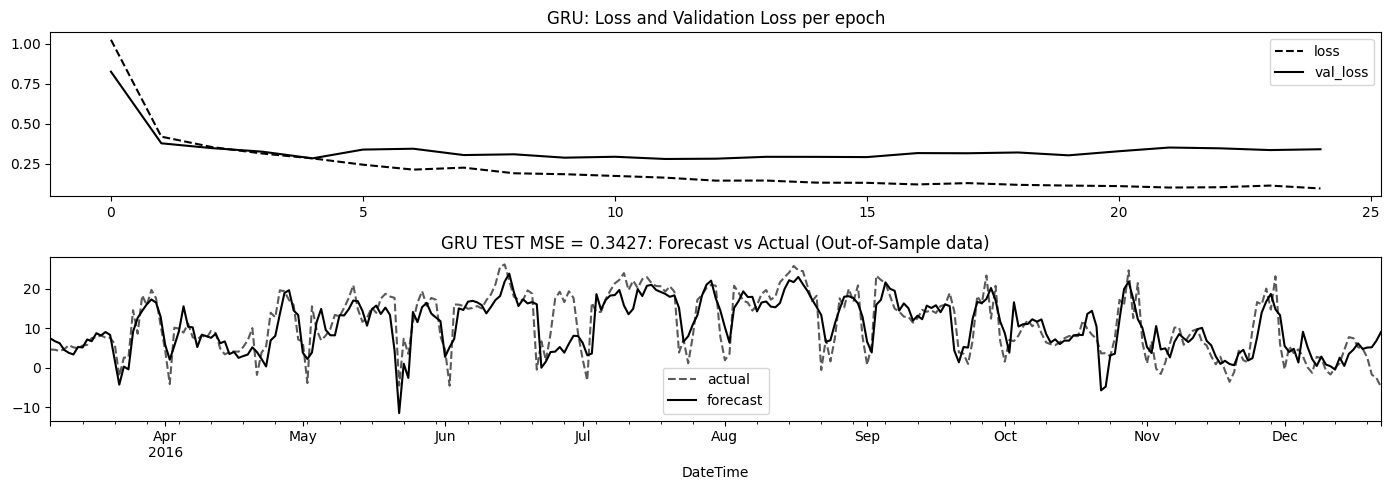

In [52]:

dw_gru, history_dw_gru = train_model_pt('GRU', **params_dw)



## Energy Consumption


0/500 - Loss:  1.0174721479415894, val_loss: 1.1818925142288208
20/500 - Loss:  0.12426621466875076, val_loss: 0.224020853638649
40/500 - Loss:  0.08468520641326904, val_loss: 0.18770036101341248
60/500 - Loss:  0.06562475860118866, val_loss: 0.16846521198749542
80/500 - Loss:  0.06475873291492462, val_loss: 0.15452450513839722
100/500 - Loss:  0.05822712928056717, val_loss: 0.14767424762248993
120/500 - Loss:  0.053724367171525955, val_loss: 0.14185890555381775
140/500 - Loss:  0.05370904132723808, val_loss: 0.13860324025154114
160/500 - Loss:  0.048707060515880585, val_loss: 0.13666799664497375
180/500 - Loss:  0.046622782945632935, val_loss: 0.1337394416332245
200/500 - Loss:  0.04282855615019798, val_loss: 0.12779469788074493
220/500 - Loss:  0.04216929152607918, val_loss: 0.13324061036109924
240/500 - Loss:  0.0420498326420784, val_loss: 0.13326039910316467
260/500 - Loss:  0.03891663998365402, val_loss: 0.12867523729801178
280/500 - Loss:  0.03923827037215233, val_loss: 0.1294425

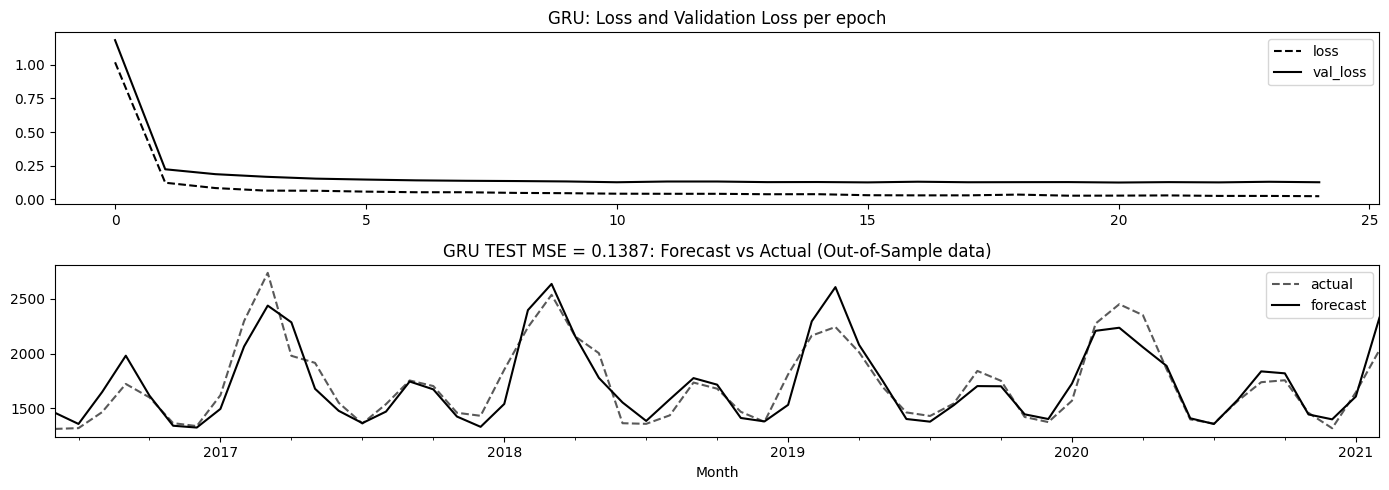

In [53]:

en_gru, history_en_gru = train_model_pt('GRU', **params_en)



## There is more


In [54]:

n_hidden = 32
input_size = x_train_en.shape[1]
n_layers = 1
output = 1


In [55]:

model_lstm_seq = torch.nn.Sequential(
    torch.nn.LSTM(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)


In [56]:

model_gru_seq = torch.nn.Sequential(
    torch.nn.GRU(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)


In [57]:

model_lstm_seq


Sequential(
  (0): LSTM(10, 32)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=32, out_features=1, bias=True)
)